In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\normal_map.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\raycast_vtx_004.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\bunnyData.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\point_cloud_sample1.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\point_cloud_sample2.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads

# Octree
An **octree** is a tree data structure where each internal node has eight children. Octrees are commonly used for spatial partitioning of 3D point clouds. Non-empty leaf nodes of an octree contain one or more points that fall within the same spatial subdivision. Octrees are a useful description of 3D space and can be used to quickly find nearby points. Open3D has the geometry type `Octree` that can be used to create, search, and traverse octrees with a user-specified maximum tree depth, `max_depth`.

## From point cloud
An octree can be constructed from a point cloud using the method `convert_from_point_cloud`. Each point is inserted into the tree by following the path from the root node to the appropriate leaf node at depth `max_depth`. As the tree depth increases, internal (and eventually leaf) nodes represents a smaller partition of 3D space.

If the point cloud has color, the the corresponding leaf node takes the color of the last inserted point. The `size_expand` parameter increases the size of the root octree node so it is slightly bigger than the original point cloud bounds to accomodate all points.

input


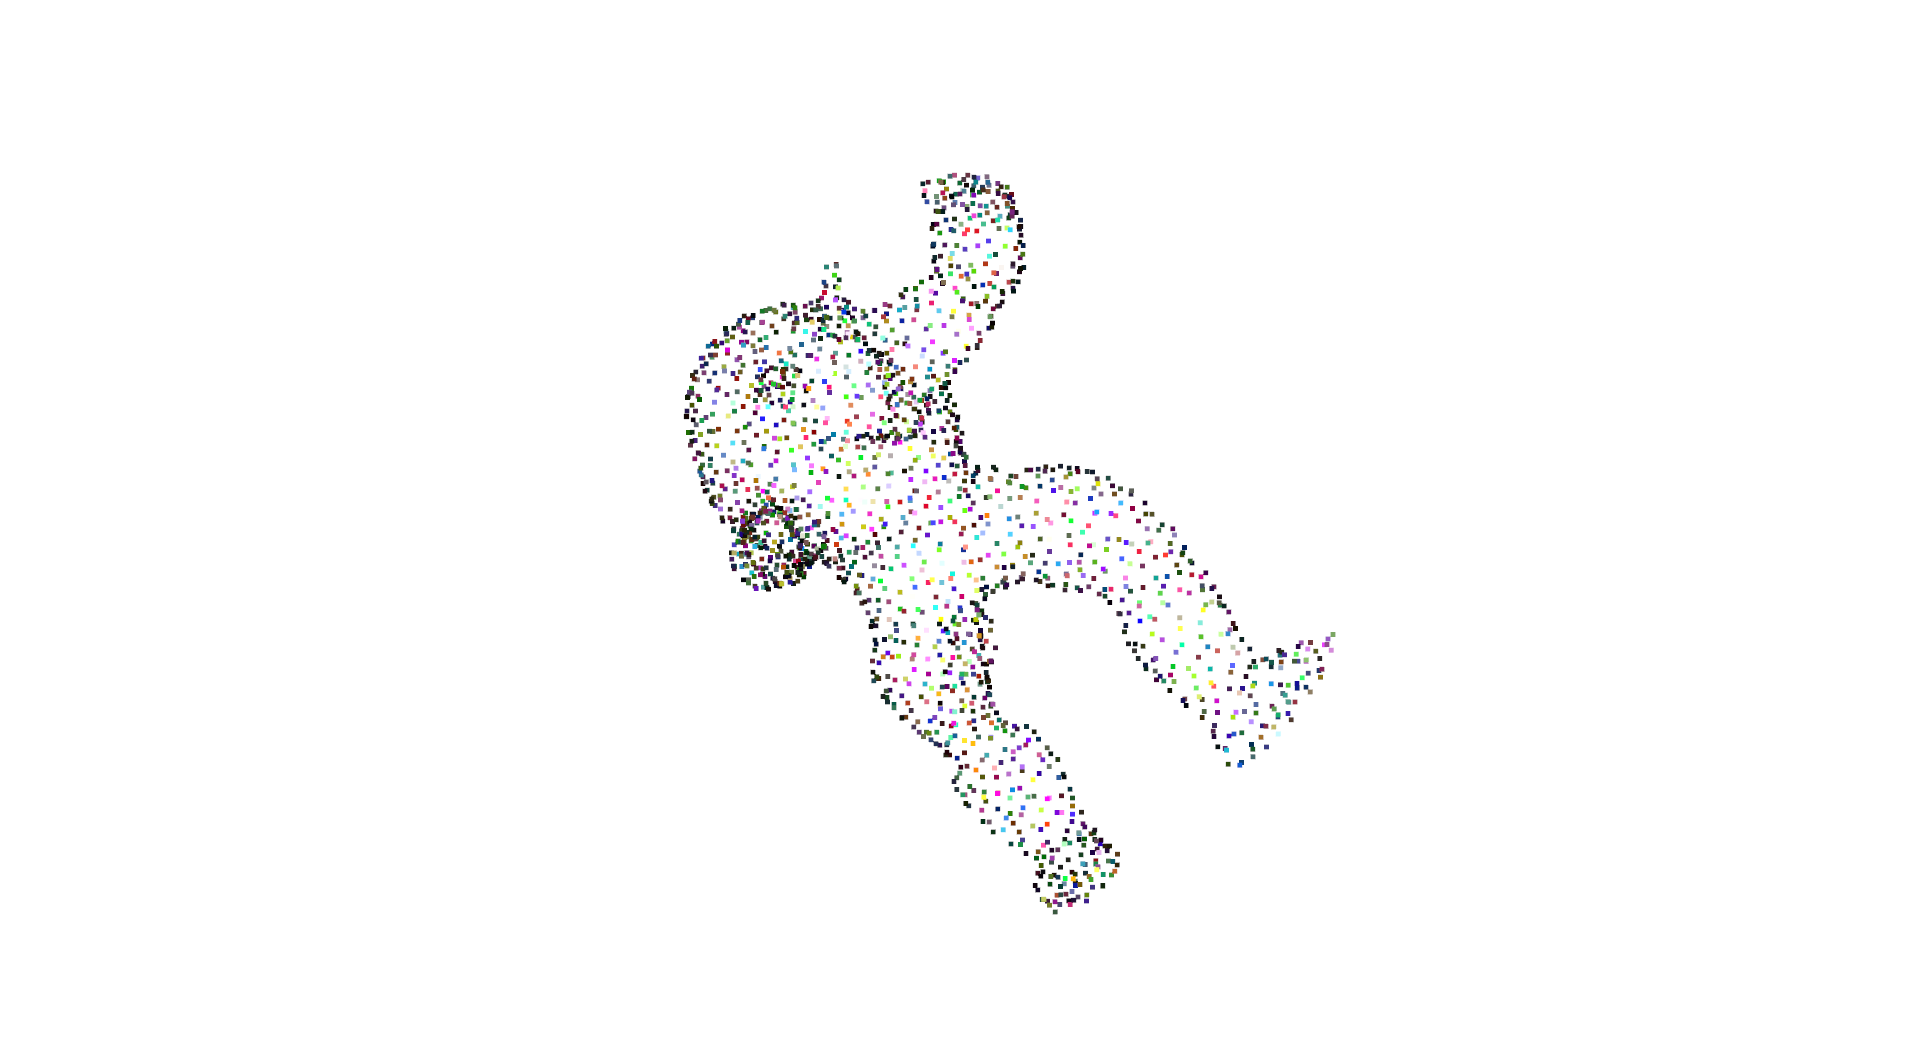

octree division


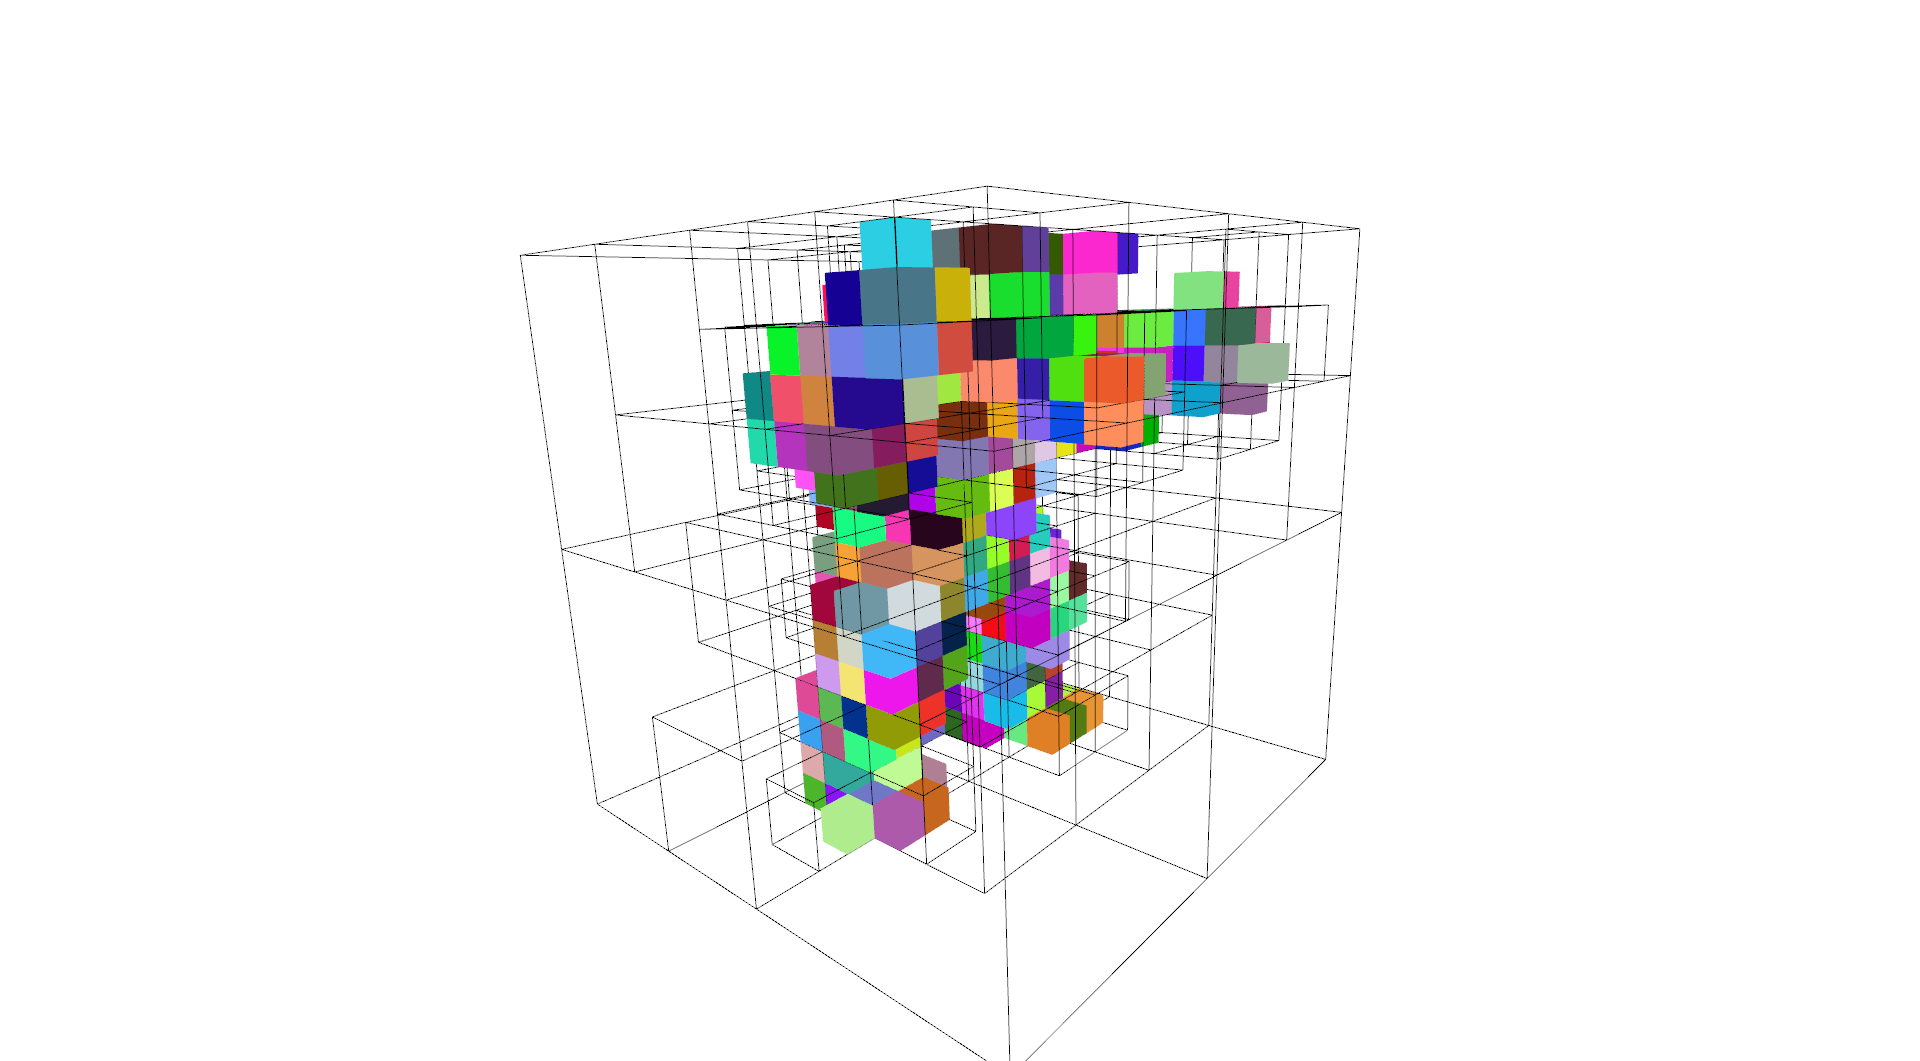

In [2]:
print('input')
N = 2000
pcd = o3dtut.get_armadillo_mesh().sample_points_poisson_disk(N)
# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

print('octree division')
octree = o3d.geometry.Octree(max_depth=4)
octree.convert_from_point_cloud(pcd, size_expand=0.01)
o3d.visualization.draw_geometries([octree])

## From voxel grid
An octree can also be constructed from an Open3D `VoxelGrid` geometry using the method `create_from_voxel_grid`. Each voxel of the input `VoxelGrid` is treated as a point in 3D space with coordinates corresponding to the origin of the voxel. Each leaf node takes the color of its corresponding voxel.

voxelization


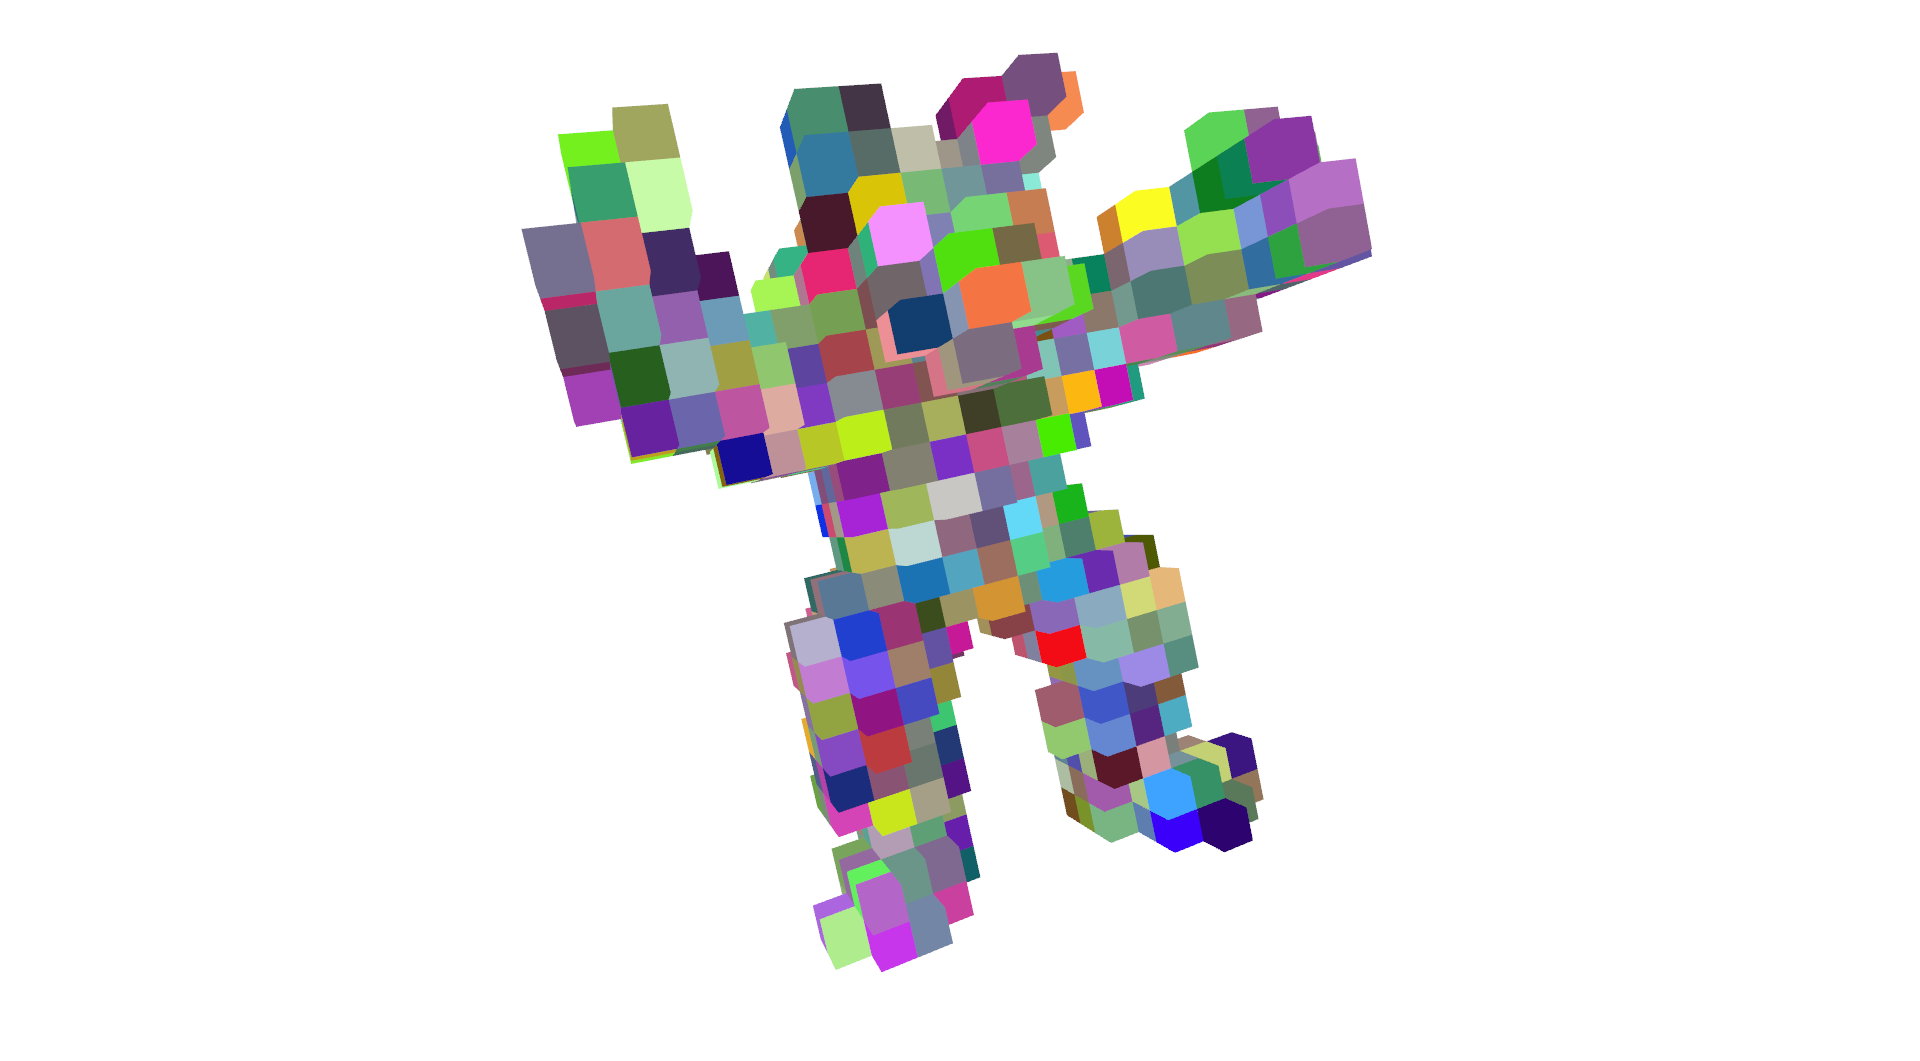

octree division


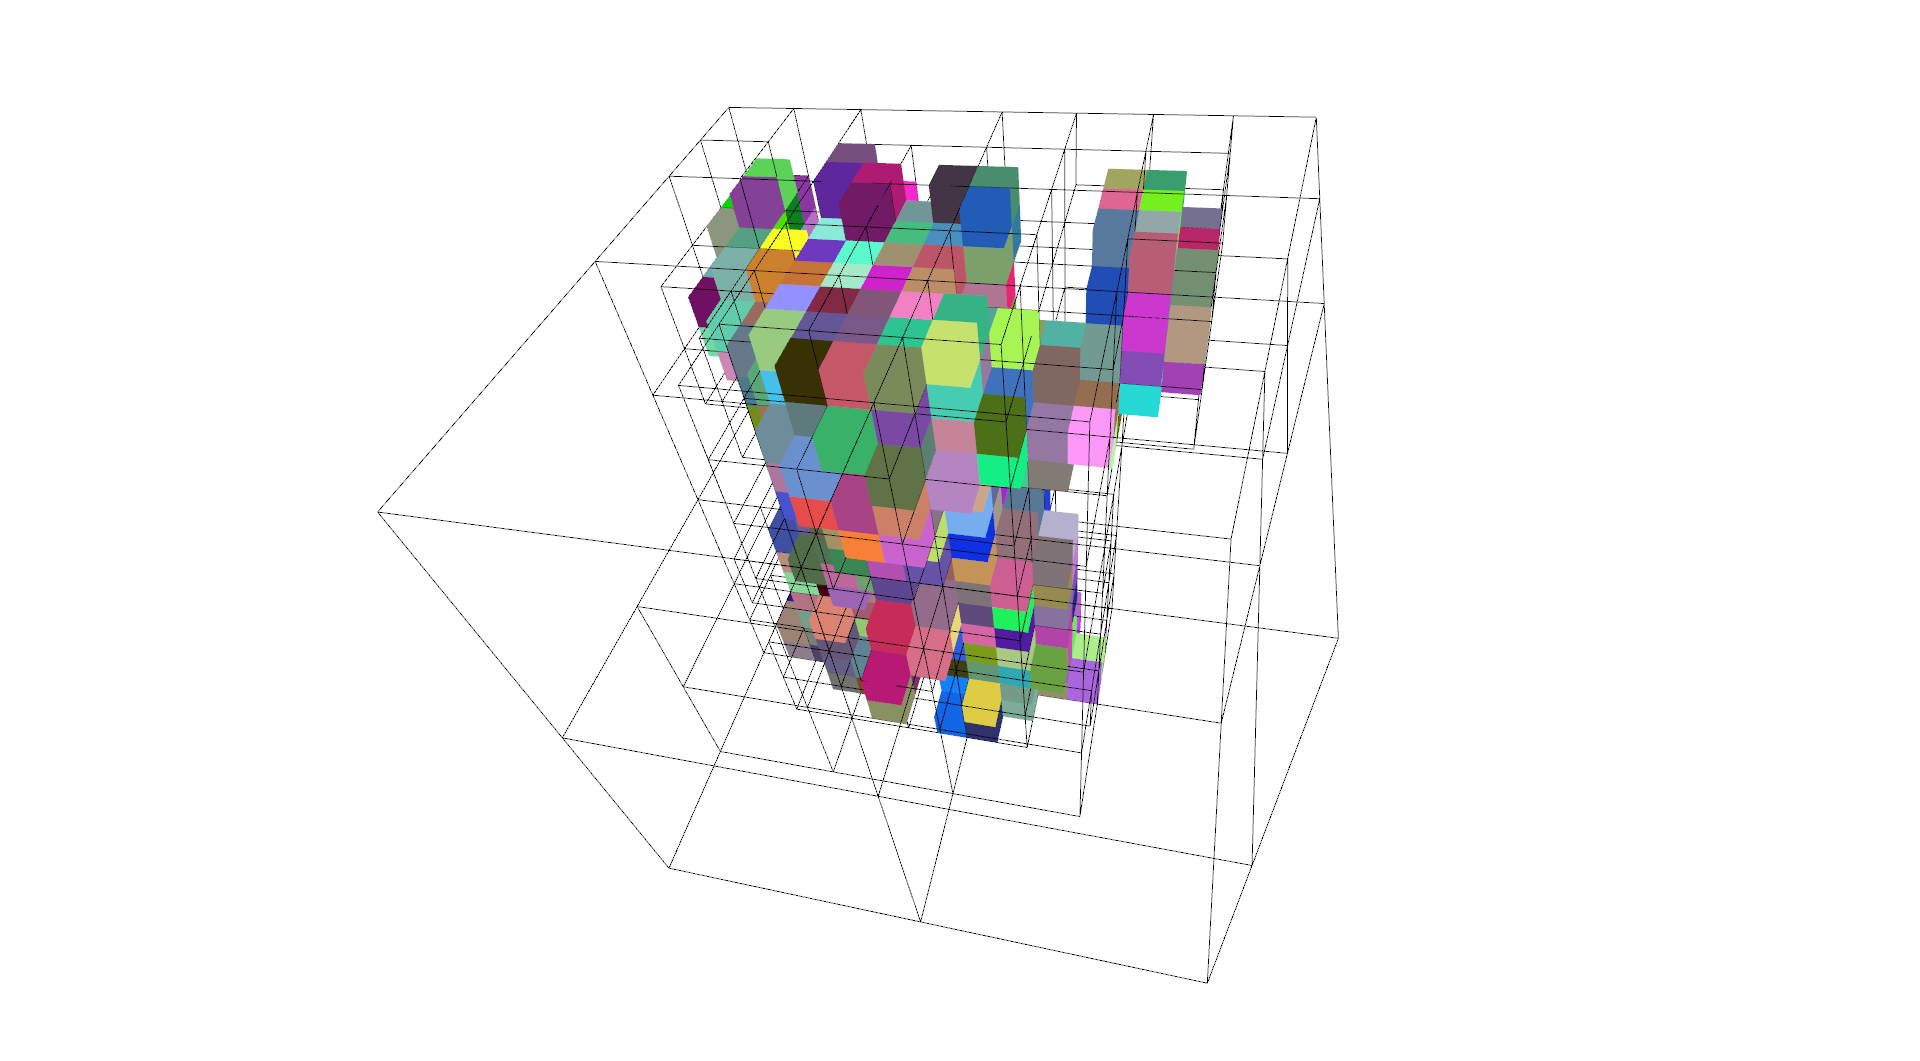

In [3]:
print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

print('octree division')
octree = o3d.geometry.Octree(max_depth=4)
octree.create_from_voxel_grid(voxel_grid)
o3d.visualization.draw_geometries([octree])

Additionally, an `Octree` can be coverted to a `VoxelGrid` with `to_voxel_grid`.

## Traversal
An octree can be traversed which can be useful for searching or processing subsections of 3D geometry. By providing the `traverse` method with a callback, each time a node (internal or leaf) is visited, additional processing can be performed.

In the following example, an early stopping criterion is used to only process internal/leaf nodes with more than a certain number of points. This early stopping ability can be used to efficiently process spatial regions meeting certain conditions.

In [5]:
def f_traverse(node, node_info):
    early_stop = False

    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            n = 0
            for child in node.children:
                if child is not None:
                    n += 1
            print(
                "{}{}: Internal node at depth {} has {} children and {} points ({})"
                .format('    ' * node_info.depth,
                        node_info.child_index, node_info.depth, n,
                        len(node.indices), node_info.origin))

            # we only want to process nodes / spatial regions with enough points
            early_stop = len(node.indices) < 250
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            print("{}{}: Leaf node at depth {} has {} points with origin {}".
                  format('    ' * node_info.depth, node_info.child_index,
                         node_info.depth, len(node.indices), node_info.origin))
    else:
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

In [6]:
octree = o3d.geometry.Octree(max_depth=4)
octree.convert_from_point_cloud(pcd, size_expand=0.01)
octree.traverse(f_traverse)

0: Internal node at depth 0 has 8 children and 2000 points ([-2.80456888 31.16605362  1.78604101])
    0: Internal node at depth 1 has 4 children and 69 points ([-2.80456888 31.16605362  1.78604101])
    1: Internal node at depth 1 has 2 children and 45 points ([-2.29956888 31.16605362  1.78604101])
    2: Internal node at depth 1 has 8 children and 416 points ([-2.80456888 31.67105362  1.78604101])
        0: Internal node at depth 2 has 2 children and 8 points ([-2.80456888 31.67105362  1.78604101])
        1: Internal node at depth 2 has 1 children and 7 points ([-2.55206888 31.67105362  1.78604101])
        2: Internal node at depth 2 has 5 children and 45 points ([-2.80456888 31.92355362  1.78604101])
        3: Internal node at depth 2 has 1 children and 5 points ([-2.55206888 31.92355362  1.78604101])
        4: Internal node at depth 2 has 4 children and 56 points ([-2.80456888 31.67105362  2.03854101])
        5: Internal node at depth 2 has 5 children and 91 points ([-2.55206

## Find leaf node containing point
Using the above traversal mechanism, an octree can be quickly searched for the leaf node that contains a given point. This functionality is provided via the `locate_leaf_node` method.

In [7]:
octree.locate_leaf_node(pcd.points[0])

(OctreePointColorLeafNode with color [0.611501, 0.720651, 0.607419] containing 1 points.,
 OctreeNodeInfo with origin [-2.67832, 31.9236, 1.84917], size 0.063125, depth 4, child_index 4)